In [1]:
import os
import time
import pandas as pd

from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

from joblib import dump

import model_prep_and_evals as mpe 

In [2]:
# **************************************************************
root = '/home/jovyan/msai4earth-esa/iceplant_detection/models/model_2k/twok_dataset/'
train_name = 'twok_train.csv'
test_name = 'twok_test.csv'

label_name = 'iceplant'

# save_model = False
# model_name = 'snow13_rfc'

#calculate_feature_importance = False

# ------------------------------
# IMPORT TRAIN DATA
X_train = pd.read_csv(os.path.join(root, train_name))
y_train = pd.read_csv(os.path.join(root, train_name)).loc[:,label_name] 
y_train = y_train.to_numpy()

# ------------------------------
# IMPORT TEST DATA
X_test = pd.read_csv(os.path.join(root, test_name))
y_test = pd.read_csv(os.path.join(root, test_name)).loc[:,label_name] 
y_test = y_test.to_numpy()

In [3]:
# ********** checkpoints ************
# X_train
# X_test.columns == X_train.columns
# X_train.columns
# mpe.test_train_proportions(y_train, y_test)

In [4]:
X_test

,x,y,pts_crs,aoi,naip_id,r,g,b,nir,ndvi,...,r_avg17,r_entr17,g_avg17,g_entr17,b_avg17,b_entr17,nir_avg17,nir_entr17,ndvi_avg17,ndvi_entr17
0,-120.489551,34.499965,EPSG:4326,point_conception,ca_m_3412037_nw_10_060_20200607,119,111,82,140,0.081081,...,110.166090,5.628500,100.044980,5.280576,81.657440,5.029983,120.197235,5.400634,0.044983,4.810615
1,-120.465340,34.469920,EPSG:4326,point_conception,ca_m_3412037_nw_10_060_20200607,90,85,77,100,0.052632,...,95.297580,5.068460,91.536330,4.659699,78.948100,4.385119,108.830450,5.407227,0.062284,4.204202
2,-120.446698,34.455653,EPSG:4326,point_conception,ca_m_3412037_nw_10_060_20200607,111,99,79,161,0.183824,...,104.086500,6.390166,94.833910,6.275495,81.349480,5.883144,125.235290,6.329957,0.103806,5.104683
3,-120.438111,34.454353,EPSG:4326,point_conception,ca_m_3412037_nw_10_060_20200607,53,63,59,101,0.311688,...,105.283740,6.378787,107.411766,6.283797,88.840830,6.013174,141.211070,5.880372,0.173010,5.446564
4,-120.444426,34.452852,EPSG:4326,point_conception,ca_m_3412037_nw_10_060_20200607,34,58,43,167,0.661692,...,41.657440,4.797743,63.802770,5.186050,47.429066,4.314510,175.916960,4.887969,0.619377,4.284339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,-120.449500,34.458661,EPSG:4326,point_conception,ca_m_3412037_nw_10_060_20200607,37,57,41,149,0.602151,...,42.083046,4.850882,59.460210,4.969392,44.923874,4.150251,158.207610,5.455522,0.577855,4.737608
519,-120.444954,34.457822,EPSG:4326,point_conception,ca_m_3412037_nw_10_060_20200607,186,168,142,187,0.002681,...,142.778550,5.979711,134.297580,5.814413,114.429070,5.773511,149.318340,5.804070,0.020761,4.547754
520,-120.438128,34.458685,EPSG:4326,point_conception,ca_m_3412037_nw_10_060_20200607,92,87,74,84,-0.045455,...,103.477510,5.909570,95.705880,5.566067,83.664360,5.260813,91.802765,5.658897,-0.055363,4.488607
521,-120.474556,34.483589,EPSG:4326,point_conception,ca_m_3412037_nw_10_060_20200607,119,107,88,126,0.028571,...,111.823530,5.687564,97.335640,5.337723,81.435990,5.195880,125.498270,4.869269,0.058824,4.719249


In [10]:
box_sides = [-1,0,3,5,7,9,11,13,15,17]
bands = ['r','g','b','nir','ndvi']


results = []
for box_s in box_sides:
    
    if box_s == -1:
        cols = bands
    elif box_s == 0:
        cols = bands + ['month', 'day_in_year']
    else:
        window_features = [band + x + str(box_s) for band in bands for x in ['_avg', '_entr']]
        cols =  bands + window_features + ['month', 'day_in_year']

    X_train_sub = X_train[cols].to_numpy()
    X_test_sub = X_test[cols].to_numpy()    

    rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
    rfc.fit(X_train_sub, y_train)
    
    preds = rfc.predict(X_test_sub)
    
    results.append(mpe.accuracy_info_df(y_test, preds))

In [11]:
R = pd.concat(results)
R['box_side'] = box_sides
R

,TN,TP,FN,FP,acc,sens,prec_P,spec,prec_N,box_side
0,378,87,39,19,88.91,69.05,82.08,95.21,90.65,-1
0,378,93,33,19,90.06,73.81,83.04,95.21,91.97,0
0,385,94,32,12,91.59,74.60,88.68,96.98,92.33,3
0,392,94,32,5,92.93,74.60,94.95,98.74,92.45,5
0,394,98,28,3,94.07,77.78,97.03,99.24,93.36,7
0,394,93,33,3,93.12,73.81,96.88,99.24,92.27,9
0,393,98,28,4,93.88,77.78,96.08,98.99,93.35,11
0,392,100,26,5,94.07,79.37,95.24,98.74,93.78,13
0,391,96,30,6,93.12,76.19,94.12,98.49,92.87,15
0,391,94,32,6,92.73,74.60,94.00,98.49,92.43,17


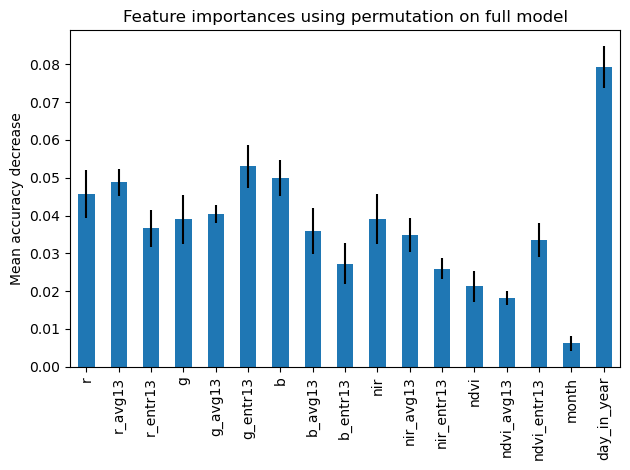

In [11]:
# result = permutation_importance(
#     rfc, 
#     X_test.to_numpy(),
#     y_test.to_numpy(),
#     n_repeats=10, 
#     random_state=42, 
#     n_jobs=2
# )

# forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()